In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.densenet import DenseNet121 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D 
from tensorflow.keras.models import Model 
from tensorflow.keras import backend as K 
from tensorflow.keras.models import load_model
import os, sys
import cv2
import random
%matplotlib inline

In [68]:
#ROOT_DIR = 
DATA_SETS = '../datasets'
#SCRIPTS = 

In [69]:
datasets_list = os.listdir(DATA_SETS)
datasets_list

['sample_submission.csv',
 'test',
 'test_tfrecords',
 'train',
 'train.csv',
 'train_annotations.csv',
 'train_tfrecords']

In [70]:
train = os.path.join(DATA_SETS, 'train')
submission = os.path.join(DATA_SETS,'sample_submission.csv')
test = os.path.join(DATA_SETS, 'test')

In [71]:
train_df = pd.read_csv(DATA_SETS+'/train.csv')
print(f'Train Data CSV: {train_df.shape[0]}')
train_df.head()

Train Data CSV: 30083


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


In [72]:
sub_df = pd.read_csv(submission)
print(f'Sub CSV: {sub_df.shape[0]}')
sub_df.head()

Sub CSV: 3582


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0,0,0,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,0,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,0,0,0,0,0,0,0,0,0,0,0


In [73]:
# label column names
label_cols = list(sub_df.columns[1:])
image_labels = train_df[label_cols].values # will be used for train validation splitting

In [74]:
# Count up the number of instances of each class (drop non-class columns from the counts) 
class_counts = train_df.sum().drop(['StudyInstanceUID','PatientID'])

In [77]:
# we plot the distribution of patients to check if there is any class imbalance in the dataset
def plot_class_distributions(values, index):
    sns.barplot(x=values, y=index)
    plt.title('Distribution of classes for the patients')
    plt.xlabel('Patient Count', fontsize=15)
    plt.ylabel('Catheter Position', fontsize=15)
    plt.show()

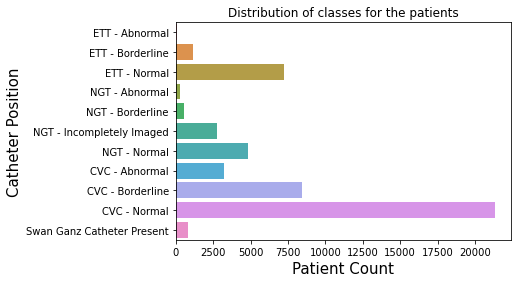

In [78]:
plot_class_distributions(class_counts.values, class_counts.index)

In [79]:
train_images = DATA_SETS + "/train/" + train_df['StudyInstanceUID'] + '.jpg'   
test_images = DATA_SETS + "/test/" + sub_df['StudyInstanceUID'] + '.jpg'
len(test_images)

3582

In [80]:
data_image = os.path.join(DATA_SETS, "train_annotations.csv")
data_image = pd.read_csv(data_image)
data_image.head()

,StudyInstanceUID,label,data
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1487, 1279], [1477, 1168], [1472, 1052], [14..."
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2..."
2,1.2.826.0.1.3680043.8.498.72921907356394389969...,CVC - Borderline,"[[801, 1207], [812, 1112], [823, 1023], [842, ..."
3,1.2.826.0.1.3680043.8.498.11697104485452001927...,CVC - Normal,"[[1366, 961], [1411, 861], [1453, 751], [1508,..."
4,1.2.826.0.1.3680043.8.498.87704688663091069148...,NGT - Normal,"[[1862, 14], [1845, 293], [1801, 869], [1716, ..."


In [81]:
# display images randomly on a grid
def display_images(image_ids, labels):
    fig = plt.figure(figsize = (16,12))
    
    for index, (image_id, label) in enumerate(zip(image_ids,labels)):
        plt.subplot(3,3, index+1)
        image = image_id + '.jpg'
        image = mpimg.imread(os.path.join(DATA_SETS, "train", image))
        plt.title(label, fontsize=12)
        plt.imshow(image,cmap='Greys')
    
    fig.tight_layout()
    plt.show()    
        

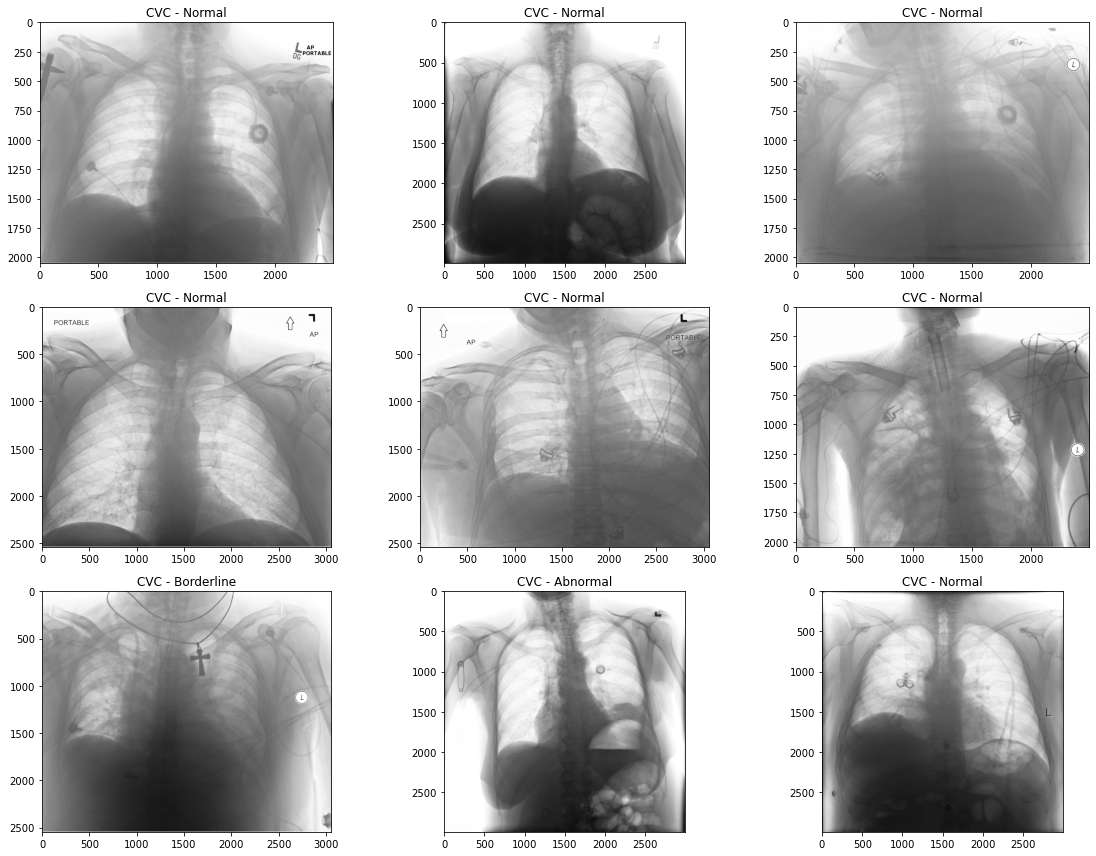

In [82]:
tmp_train = data_image.sample(9)
image_ids = tmp_train["StudyInstanceUID"].values
labels = tmp_train['label'].values
display_images(image_ids, labels)

In [83]:
# now we check for any kinds of data leakage between any two data sets, train-test, train-valid, valid-test
def check_for_leakage(df1, df2, patient_col):
    
    df1_unique = set(df1[patient_col])
    df2_unique = set(df2[patient_col])
    
    common_patients = df1_unique.intersection(df2_unique)
    
    return True if len(common_patients) > 0 else False
    
    

In [84]:
check_for_leakage(train_df, sub_df, 'StudyInstanceUID')

False

In [85]:
# for making validation set from given train set
def make_val_set(data, val_size):
    val_patientid = random.sample(list(train_df['PatientID'].unique()),int(val_size*len(train_df['PatientID'].unique())))
    df_train = data[~data['PatientID'].isin(val_patientid)]
    df_val = data[data['PatientID'].isin(val_patientid)]
    return df_train, df_val

In [86]:
df_train, df_val = make_val_set(train_df, val_size=0.2)

In [87]:
check_for_leakage(df_train, df_val, 'PatientID')

False

In [88]:
print(f'Train Data Size: {df_train.shape[0]}')
print(f'Validation Data Size: {df_val.shape[0]}')

Train Data Size: 24486
Validation Data Size: 5597


In [89]:
TRAIN_IMAGE_DIR = DATA_SETS + '/train/'
TEST_IMAGE_DIR = DATA_SETS + '/test/'

In [91]:
# with augmentation
def get_train_generator(df, image_dir, image_id, label_names, shuffle=True, batch_size=32, seed=1, target_width=256, target_height=256):
    print('Train Generator Preparation: ')
    
    # first we normalize the images and add light augmentation to the images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization=True,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.2
    )
    
    # next we flow from data frame with a certain batch size.
    # This flows the images from the directory
    generator = image_generator.flow_from_dataframe(
        dataframe=df,
        directory=image_dir,
        x_col=image_id,
        y_col=label_names,
        class_mode="raw",
        classes=label_names,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=1,
        target_size=(target_width, target_height)
    )
    
    return generator
    

In [92]:
# create image generator
def get_image_generator(train_df, image_dir, image_id, label_names, shuffle=True, batch_size=32, seed=1, target_width=256, target_height=256, sample_size=100):
    # generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col=image_id,
        y_col=label_names,
        class_mode='raw',
        batch_size=sample_size,
        shuffle=shuffle,
        target_size=(target_width, target_height)
    )
    
    batch = raw_train_generator.next() 
    data_sample = batch[0] 
    
    # use sample to fit mean and std for test set generator
    # featurewise mean and normalization is done on all the images
    image_generator = ImageDataGenerator( 
        featurewise_center=True, 
        featurewise_std_normalization= True) 
    
    # fit generator to sample from training data 
    image_generator.fit(data_sample)
    
    return image_generator

In [93]:
def get_generator(df, image_dir, x_col, y_cols, image_generator, batch_size=32, seed=1, target_width = 256, target_height = 256):
    # get valid generator
    
    generator = image_generator.flow_from_dataframe( 
        dataframe=df, 
        directory=image_dir, 
        x_col=x_col, y_col=y_cols, 
        class_mode="raw", 
        batch_size=batch_size, 
        shuffle=False, 
        seed=seed, 
        target_size=(target_width,target_height)
    )
    
    return generator

3        1.2.826.0.1.3680043.8.498.68286643202323212801...
12       1.2.826.0.1.3680043.8.498.96906149082473772016...
19       1.2.826.0.1.3680043.8.498.10129559062963528496...
22       1.2.826.0.1.3680043.8.498.43628413720237813055...
25       1.2.826.0.1.3680043.8.498.10335903250150902074...
                               ...                        
30059    1.2.826.0.1.3680043.8.498.25116746918324400178...
30060    1.2.826.0.1.3680043.8.498.75445875862496758679...
30067    1.2.826.0.1.3680043.8.498.85543708701293903513...
30070    1.2.826.0.1.3680043.8.498.10908982342413107306...
30081    1.2.826.0.1.3680043.8.498.95092491950130838685...
Name: StudyInstanceUID, Length: 5597, dtype: object

In [99]:
def append_ext(fn, ext='.jpg'):
    return fn+ext

df_train['StudyInstanceUID'] = df_train['StudyInstanceUID'].apply(append_ext)
df_val['StudyInstanceUID'] = df_val['StudyInstanceUID'].apply(append_ext)
sub_df['StudyInstanceUID'] = sub_df['StudyInstanceUID'].apply(append_ext)

<ipython-input-99-a2aae0dcebbe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['StudyInstanceUID'] = df_train['StudyInstanceUID'].apply(append_ext)
<ipython-input-99-a2aae0dcebbe>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['StudyInstanceUID'] = df_val['StudyInstanceUID'].apply(append_ext)


In [100]:
sub_df['StudyInstanceUID'][0]

'1.2.826.0.1.3680043.8.498.46923145579096002617106567297135160932.jpg'

In [101]:
train_generator = get_train_generator(df_train, TRAIN_IMAGE_DIR, "StudyInstanceUID", label_cols)
raw_image_generator = get_image_generator(df_train, TRAIN_IMAGE_DIR, "StudyInstanceUID", label_cols)
valid_generator = get_generator(df_val, TRAIN_IMAGE_DIR, "StudyInstanceUID", label_cols, raw_image_generator)
test_generator= get_generator(sub_df, TEST_IMAGE_DIR, "StudyInstanceUID", label_cols, raw_image_generator)

Train Generator Preparation: 


E:\ANACONDA\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:219: UserWarning: `classes` will be ignored given the class_mode="raw"
  warnings.warn('`classes` will be ignored given the class_mode="{}"'


Found 24486 validated image filenames.
Found 24486 validated image filenames.
Found 5597 validated image filenames.
Found 3582 validated image filenames.


# Model Building

## Custom Weighted Loss Function and Frequency analysis

## Training Model